 ***Step 1: Data Cleaning and Preprocessing ***
*   Load the dataset:
*   Convert categorical variables to numerical:
*  Drop irrelevant columns:
*  Handle missing values (if any):

In [1]:
from google.colab import files
upload = files.upload()

Saving Bank Customer Churn Prediction.csv to Bank Customer Churn Prediction.csv


In [2]:
import pandas as pd
# Load the dataset
file_path = 'Bank Customer Churn Prediction.csv'
df = pd.read_csv(file_path)

In [3]:
# Convert categorical variables to numerical
df = pd.get_dummies(df, columns=['country', 'gender'], drop_first=True)

In [4]:
# Drop customer_id as it is not relevant for prediction
df = df.drop(columns=['customer_id'])

In [5]:
# Check for missing values
print(df.isnull().sum())

credit_score        0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
country_Germany     0
country_Spain       0
gender_Male         0
dtype: int64


**Step 2: Exploratory Data Analysis (EDA)**

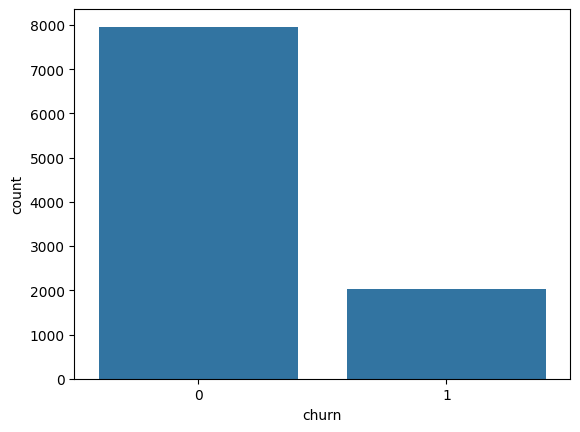

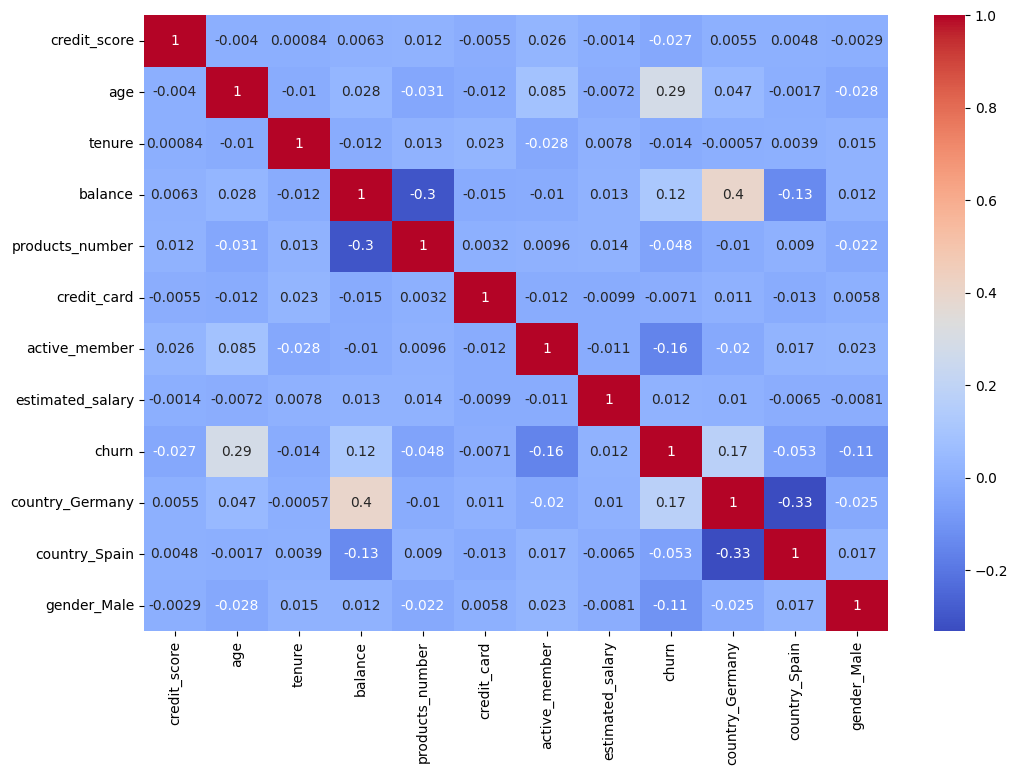

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of churn
sns.countplot(x='churn', data=df)
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

In [7]:
# Display correlation with churn
print(df.corr()['churn'].sort_values(ascending=False))

churn               1.000000
age                 0.285323
country_Germany     0.173488
balance             0.118533
estimated_salary    0.012097
credit_card        -0.007138
tenure             -0.014001
credit_score       -0.027094
products_number    -0.047820
country_Spain      -0.052667
gender_Male        -0.106512
active_member      -0.156128
Name: churn, dtype: float64


**Step 3: Feature Engineering**

In [8]:
from sklearn.preprocessing import StandardScaler
# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df.drop('churn', axis=1))

In [9]:
# Create a DataFrame with scaled features
df_scaled = pd.DataFrame(scaled_features, columns=df.columns[:-1])
df_scaled['churn'] = df['churn'].values

**Step 4: Model Selection and Training**

**Random Forest**

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [11]:
# Split data
X = df.drop('churn', axis=1)
y = df['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Train Random Forest model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [13]:
# Predict on test data
rf_pred = rf.predict(X_test)

**Step 5: Model Evaluation and Fine-Tuning**

In [14]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [15]:
# Evaluate Random Forest model
y_pred_rf = rf.predict(X_test)
print("Random Forest Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print(f"Precision: {precision_score(y_test, y_pred_rf)}")
print(f"Recall: {recall_score(y_test, y_pred_rf)}")
print(f"F1 Score: {f1_score(y_test, y_pred_rf)}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_rf)}")

Random Forest Metrics:
Accuracy: 0.8675
Precision: 0.7666666666666667
Recall: 0.4681933842239186
F1 Score: 0.5813586097946287
ROC-AUC: 0.7166729211100925


In [16]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Best Score: 0.858554390314759


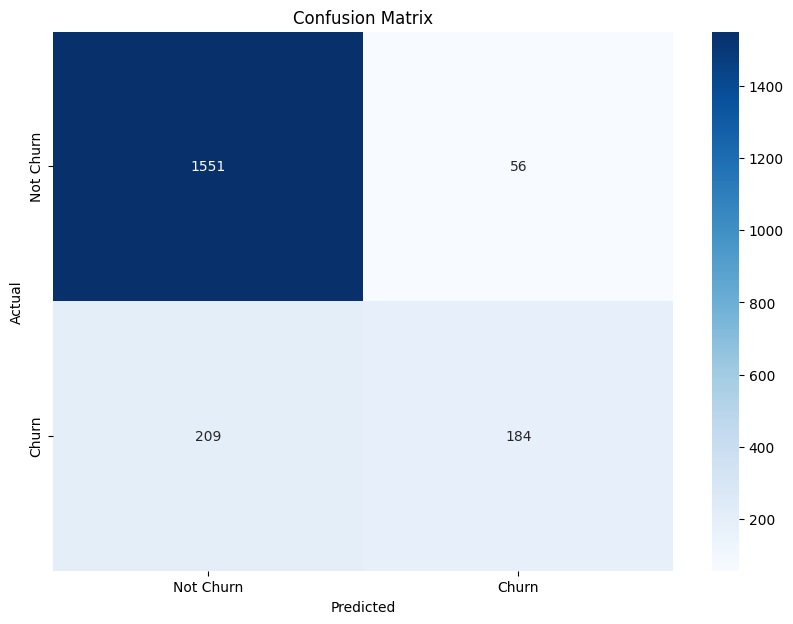

In [17]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, rf_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

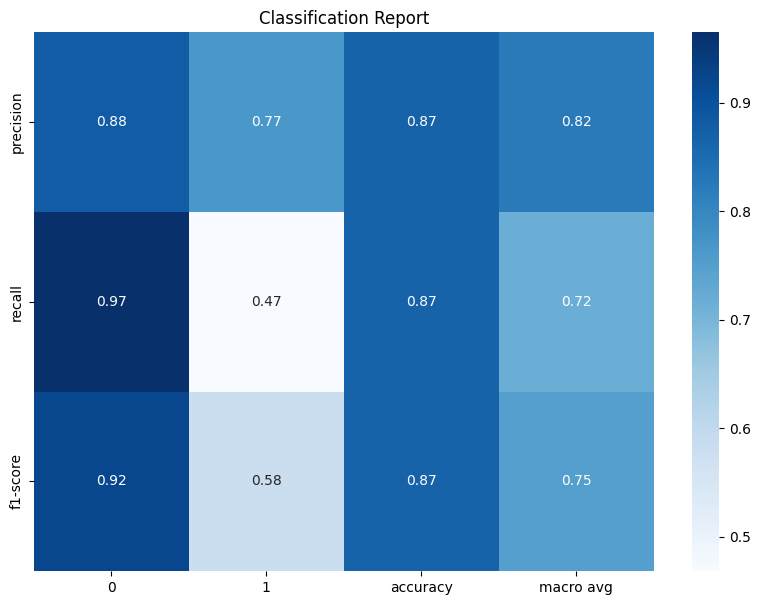

In [18]:
def plot_classification_report(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True)
    df_report = pd.DataFrame(report).transpose()

    plt.figure(figsize=(10, 7))
    sns.heatmap(df_report.iloc[:-1, :-1].T, annot=True, cmap='Blues', fmt='.2f')
    plt.title('Classification Report')
    plt.show()

# Plot the classification report
plot_classification_report(y_test, rf_pred)

**Step 6: Model Implementation**

In [19]:
!pip install Flask
!pip install pyngrok
!pip install joblib

In [20]:
import os
print(os.getcwd())

/content


In [21]:
file_path = 'Bank Customer Churn Prediction.csv'

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import joblib
# Save the model
joblib.dump(rf, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [ ]:
import joblib
from flask import Flask, request, jsonify
import numpy as np

# Load your model
model = joblib.load('random_forest_model.pkl')

app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    try:
        # Get JSON data from request
        data = request.get_json(force=True)

        # Convert JSON data to list of features (make sure to align this with your model's expected features)
        features = [df['age'], df['tenure'], df['balance'], df['gender_male'], df['gender_female'], df['product_1'], data['product_2']]
        features = np.array(features).reshape(1, -1)

        # Make prediction
        prediction = model.predict(features)

        # Return prediction as JSON
        return jsonify({'prediction': int(prediction[0])})
    except Exception as e:
        return jsonify({'error': str(e)})

if __name__ == "__main__":
    app.run(host='0.0.0.0', port=5000)

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit


In [ ]:
!ngrok authtoken 2jY2uICOTG8mt9fjzVd2R8DdAS4_KdHVh4r6e9hWod21Fsvi

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
# Step 1: Install ngrok and other necessary libraries
!pip install pyngrok flask joblib

# Step 2: Import required libraries
from pyngrok import ngrok
from flask import Flask, request, jsonify
import numpy as np
import joblib
import threading

# Step 3: Load your model (ensure 'model.pkl' is in the current directory)
model = joblib.load('random_forest_model.pkl')

# Step 4: Define your Flask app
app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    try:
        # Get JSON data from request
        data = request.get_json(force=True)

        # Convert JSON data to list of features (make sure to align this with your model's expected features)
        features = [data['age'], data['tenure'], data['balance'], data['gender_male'], data['gender_female'], data['product_1'], data['product_2']]
        features = np.array(features).reshape(1, -1)

        # Make prediction
        prediction = model.predict(features)

        # Return prediction as JSON
        return jsonify({'prediction': int(prediction[0])})
    except Exception as e:
        return jsonify({'error': str(e)})

# Step 5: Function to run the Flask app
def run_flask():
    app.run(host='0.0.0.0', port=5000)

# Step 6: Set up ngrok with your authtoken
!ngrok authtoken YOUR_AUTH_TOKEN  # Replace YOUR_AUTH_TOKEN with your actual ngrok authtoken

# Step 7: Start the ngrok tunnel
public_url = ngrok.connect(port='5000')
print(f"Public URL: {public_url}")

# Step 8: Run Flask app in a separate thread
thread = threading.Thread(target=run_flask)
thread.start()

In [ ]:
!nohup python app.py &

nohup: appending output to 'nohup.out'


In [ ]:
import requests

# Define the public URL from ngrok
url = 'YOUR_NGROK_PUBLIC_URL/predict'

# Define a sample input
data = {
    "age": 30,
    "tenure": 5,
    "balance": 50000,
    "gender_male": 1,
    "gender_female": 0,
    "country_1": 1,
    "country_2": 0,
    "country_3": 0
}

# Send the POST request
response = requests.post(url, json=data)
print(response.json())